In [19]:
from Subspace import Subspace
from Inference import Inference 
from model import Model
import matplotlib.pyplot as plt
from autograd import numpy as np
import CurveSubspace as curve
import util
import time

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import pandas as pd

In [3]:
data = pd.read_csv('../example/hw7_data.csv')

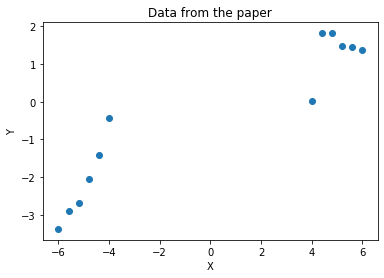

In [4]:
# visualize the data used in original paper
data = pd.read_csv('../example/hw7_data.csv')
x, y = data['x'].values, data['y'].values
plt.scatter(x, y)
plt.title('Data from the paper')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Create the Neural Network

In [5]:
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c) ** 2)

###neural network model design choices

width = 5 #7
hidden_layers = 1 #2
input_dim = 1
output_dim = 1

architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': 'rbf',
                'activation_fn_params': 'c=0, alpha=1',
                'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y = 0.25)

# use MSE result as params_init
params = {'step_size': 1e-3, #1e-3
          'max_iteration': 5000, #5000
          'random_restarts': 1}

# fit my neural network to minimize MSE on the given data
#my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Text(0, 0.5, 'Y')

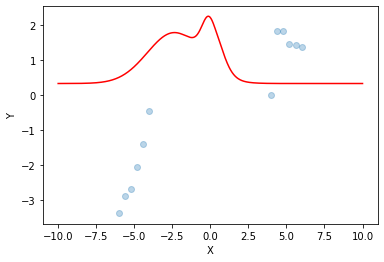

In [6]:
# visualize the model's prediction
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y')

## Curve Subspace

In [7]:
#width = 5
#hidden_layers = 2
net = curve.BaseNet(1, width, hidden_layers)

optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.MSELoss()

dataset = TensorDataset(torch.Tensor(x.reshape(-1, 1)), torch.Tensor(y))
loader = DataLoader(dataset, batch_size=64, shuffle = True)

# for training the two endpoints
#params_base = {'epochs': 1000}
params_base = params

In [8]:
def CurveNetGen(w0, w1):
    return curve.CurveNet(1, width, hidden_layers, w0, w1)

# for training the mid-points
params_curve = {'sample_size': 500}

In [9]:
"""
my_subspace = Subspace.create(subspace_type="curve", net = net, loader = loader, params_base = params_base, 
                           optimizer = optimizer, criterion = criterion, 
                           curve_net_gen = CurveNetGen, params_curve = params_curve)
"""
my_subspace = Subspace.create(subspace_type="curve", net = net, params_base = params_base, nn = my_nn, 
                              X = x, y = y, loader = loader, criterion = criterion, 
                              curve_net_gen = CurveNetGen, params_curve = params_curve)

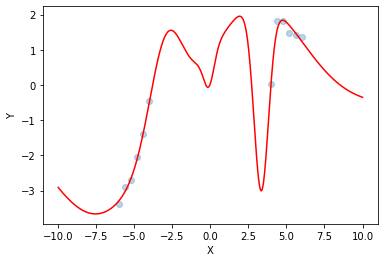

In [14]:
with torch.no_grad():
    my_subspace.net.load_state_dict(e[1])
    x_test = torch.Tensor(np.linspace(-10, 10, 1000).reshape(-1,1))
    y_test = my_subspace.net(x_test)
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test.numpy(), y_test.numpy(), color = 'red')
plt.xlabel('X');
plt.ylabel('Y');

In [10]:
# change callback to control printing frequency (0 = no printing)
# epochs for training mid points
# restart: whether to get new endpoints or train on exisiting ones
my_subspace.collect_vector(epochs = 200, callback = 20, restart = False)
P, w = my_subspace.get_space()

[epoch 1] loss: 0.218
[epoch 21] loss: 0.214
[epoch 41] loss: 0.216
[epoch 61] loss: 0.213
[epoch 81] loss: 0.212
[epoch 101] loss: 0.213
[epoch 121] loss: 0.211
[epoch 141] loss: 0.210
[epoch 161] loss: 0.211
[epoch 181] loss: 0.209


## HMC

In [17]:
hmc_tune_params={'step_size':1e-3,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [20]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.001
HMC 400: accept rate of 99.75 with step size 0.002497705539285073
HMC 600: accept rate of 99.83333333333333 with step size 0.003997705539285073
HMC 800: accept rate of 99.75 with step size 0.005487590641486831
HMC 1000: accept rate of 99.7 with step size 0.006913965042708839
HMC 1200: accept rate of 99.66666666666667 with step size 0.008413965042708839
HMC 1400: accept rate of 99.71428571428571 with step size 0.009913965042708838
HMC 1600: accept rate of 99.6875 with step size 0.011410622321038344
HMC 1800: accept rate of 99.33333333333333 with step size 0.01288926454169545
HMC 2000: accept rate of 98.9 with step size 0.014135934494752308
HMC 2200: accept rate of 98.72727272727273 with step size 0.01563593449475231
HMC 2400: accept rate of 98.66666666666667 with step size 0.017013074389933266
HMC 2600: accept rate of 97.96153846153847 with step size 0.018513074389933267
HMC 2800: accept rate of 96.96428571428571 with step size 0.019377

In [23]:
end-begin

913.725914478302

In [21]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

In [ ]:
import pickle

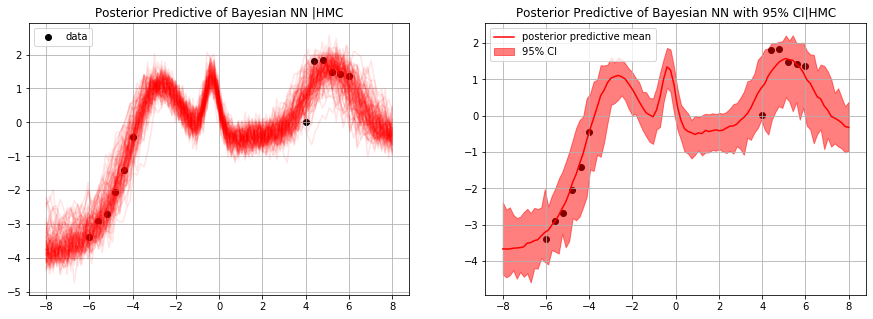

In [22]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

## BBB

In [24]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [ ]:
my_inference = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w,  tune_params=bbb_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -108.8260180433413; gradient mag: 19.633144395777737
Iteration 200 lower bound -63.29197075801503; gradient mag: 37.30669733464698
Iteration 400 lower bound -22.32408168963131; gradient mag: 18.772623856247545
Iteration 600 lower bound -13.490043930470046; gradient mag: 8.656348351625041
Iteration 800 lower bound -10.854784859016759; gradient mag: 4.744636714241785
Iteration 1000 lower bound -9.718466432749274; gradient mag: 4.086131787934881
Iteration 1200 lower bound -9.216847596420026; gradient mag: 2.948008643394714
Iteration 1400 lower bound -8.934629745864484; gradient mag: 2.8354820382887285


## Method

We perform inference in a K-dimensional subspace $\mathcal{S}$ defined by 
\begin{aligned}
\mathcal{S} &= \{w|w = \hat{w} + z_1v_1 + \ldots + z_Kv_K\} \\
&= \{w|w = \hat{w} + Pz\}.
\end{aligned}
With a fixed $\hat{w}$ and projection matrix $P$, over which we perform inference

### Random